# Implementation of an Autoencoder (VAE)
#### based on the VE implementation and https://sannaperzon.medium.com/paper-summary-variational-autoencoders-with-pytorch-implementation-1b4b23b1763a
## Simple linear VAE with one layer into hidden (latent) space 748 -> 256 -> 12 and back 12 -> 256 -> 748

#### Build for MINST datasets

In [1]:
#import os
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['NUMEXPR_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.transforms import ToTensor

In [2]:
batch_size = 64

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"   ### needed if Nvidia GPU is available and wanted to use the GPU
print(f"Using {device} device")

Using cuda device


In [4]:
### Building the neural network structure ####

dim_encoder_decoder=784
dim_hidden=256
dim_latent=12

class VAE(nn.Module):
    def __init__(self, dim_encoder_decoder=784, dim_hidden=256, dim_latent=12):
        super(VAE , self).__init__()
        
        self.decoder = nn.Sequential(                             # sequential operation of the following code:
            nn.Linear(dim_latent, dim_hidden),                    # decoding laten layer (12 -> 256 nodes)
            nn.ReLU(),                                            #
            nn.Linear(dim_hidden, dim_encoder_decoder),           # reconstruction of image (256 -> 784)
            nn.Sigmoid()                                          # rescale values between ]0,1[ by the sigmoidal function
        )
        
        self.encoder_layer = nn.Sequential(                       # sequential operation of the following code:
            nn.Linear(dim_encoder_decoder, dim_hidden),           # decoding laten layer (784 -> 256 nodes)
            nn.ReLU(),      
        )
        
        self.hidden_to_mu = nn.Linear(dim_hidden, dim_latent)     # hidden layer in dim_latent for mu
        self.hidden_to_sigma = nn.Linear(dim_hidden, dim_latent)  # hidden layer in dim_latent for sigma


    def encoder(self, x):
        hidden_layer = self.encoder_layer(x)
        mu = self.hidden_to_mu(hidden_layer)
        sigma = self.hidden_to_sigma(hidden_layer)
        return mu , sigma

        
    def forward(self, x):                                        # 
        mu, sigma = self.encoder(x)
        epsilon = torch.randn_like(sigma)                        #### "Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1"
        z = mu + sigma*epsilon
        decoded = self.decoder(z) 
        return decoded , mu, sigma , z


model = VAE().to(device) #### this is needed for cuda
print(model)


VAE(
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (encoder_layer): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (hidden_to_mu): Linear(in_features=256, out_features=12, bias=True)
  (hidden_to_sigma): Linear(in_features=256, out_features=12, bias=True)
)


In [5]:
loss_fn = nn.MSELoss()                                        ### nn.MSELoss() (Mean Square Error) for regression tasks
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, )#

938it [00:09, 98.40it/s, loss_total=8.42e+5] 
938it [00:11, 84.74it/s, loss_total=9.77e+4]
938it [00:10, 88.72it/s, loss_total=7.58e+4] 
938it [00:08, 104.63it/s, loss_total=6.43e+4]
938it [00:09, 98.10it/s, loss_total=5.23e+4] 
938it [00:09, 95.92it/s, loss_total=3.88e+4] 
938it [00:10, 90.15it/s, loss_total=2.56e+4]
938it [00:09, 97.15it/s, loss_total=1.43e+4]
938it [00:09, 98.27it/s, loss_total=6.79e+3] 
938it [00:09, 96.56it/s, loss_total=3.14e+3] 
938it [00:10, 93.77it/s, loss_total=1.68e+3] 
938it [00:09, 101.71it/s, loss_total=1.04e+3]
938it [00:09, 101.82it/s, loss_total=722] 
938it [00:09, 98.57it/s, loss_total=524] 
938it [00:09, 100.24it/s, loss_total=388] 
938it [00:08, 106.74it/s, loss_total=293] 
938it [00:08, 114.73it/s, loss_total=222] 
938it [00:08, 112.37it/s, loss_total=171] 
938it [00:10, 91.42it/s, loss_total=133] 
938it [00:09, 99.53it/s, loss_total=107]  
938it [00:10, 92.68it/s, loss_total=90.4] 
938it [00:11, 84.07it/s, loss_total=81.9]
938it [00:09, 97.57it/s,

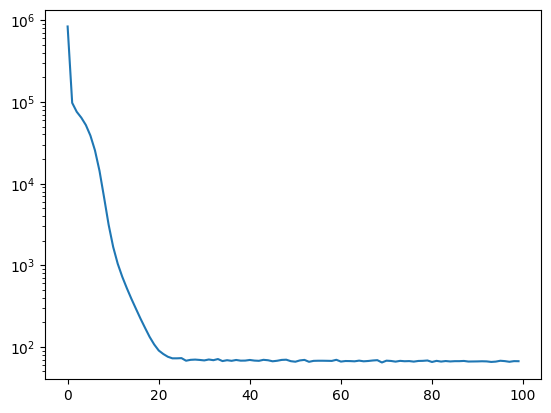

In [6]:
from tqdm import tqdm
n_epochs = 100

list_loss = []
torch.manual_seed(42)
for epoch in range(n_epochs):
    loop = tqdm(enumerate(train_dataloader))
    loss_total = 0
    for batch , (X, label) in loop:
        X = X.reshape(-1, dim_encoder_decoder).to(device)
        pred , mu, sigma , _ = model(X)
        re_loss = loss_fn(pred, X)
        kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = re_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        loop.set_postfix(loss_total=loss_total)
    list_loss.append(loss_total)
plt.plot([i for i,x in enumerate(list_loss)], list_loss)
plt.yscale("log")
plt.show()

In [7]:
torch.save(model, 'VAE_MSE_100epoch_lr1e-4.pth')